In [35]:
import numpy as np
import torch
import matplotlib.pyplot as pl
from pathlib import Path
from skimage import io

from skimage import segmentation
from skimage import filters

In [36]:
"""if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)"""

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

In [37]:
import os
import sys
sys.path.append('../code/')

In [38]:
import sys
from SWGG import SWGG_CP
from utils import sort_to_plan
from generate_data import make_data

In [39]:
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent, 'data/Images/PanSharpning')

In [34]:
def normalize(L):
    I=torch.clone(L)
    for i in range(I.shape[-1]):
        I[:,:,i]/=I[:,:,i].max()
    return np.clip(I,0,1)

def normalize2(L):
    I=torch.clone(L)
    for i in range(I.shape[-1]):
        I[:,:,i]/=I[:,:,i].max()
    I=I+.2 #To add luminosity
    return np.clip(I,0,1)

In [96]:
#4 canals
#Is_1d=torch.from_numpy(io.imread(data_path+"/Mexi_urb_PAN.tif").astype(float))
#It=torch.from_numpy(io.imread(data_path+"/Mexi_urb_MS.tif").astype(float))

#Is_1d=torch.from_numpy(io.imread(data_path+"/Trend_PAN.tif").astype(float))
#It=torch.from_numpy(io.imread(data_path+"/Trend_MS.tif").astype(float))

Is_1d=torch.from_numpy(io.imread(data_path+"/Mexi_nat_PAN.tif").astype(float))
It=torch.from_numpy(io.imread(data_path+"/Mexi_nat_MS.tif").astype(float))

#8 canals low values
#Is_1d=torch.from_numpy(io.imread(data_path+"/Munich_nat_PAN.tif").astype(float))
#It=torch.from_numpy(io.imread(data_path+"/Munich_nat_MS.tif").astype(float))

In [97]:
if It.shape[-1]==4:
    It_RGB=It[:,:,(2,1,0)]
    #Scaling and embedding in 3D for source
    Is_3d=torch.concat((Is_1d[:,:,None],Is_1d[:,:,None],Is_1d[:,:,None]),dim=-1)
    Is_3d=normalize2(Is_3d)
    #Scaling for target
    It_RGB=normalize2(It_RGB)
    
    
if It.shape[-1]==8:
    It_RGB=It[:,:,(4,2,1)]
    #Scaling and embedding in 3D for source
    Is_3d=torch.concat((Is_1d[:,:,None],Is_1d[:,:,None],Is_1d[:,:,None]),dim=-1)
    Is_3d=normalize(Is_3d)
    #Scaling for target
    It_RGB=normalize(It_RGB)

Text(0.5, 1.0, 'Target Image')

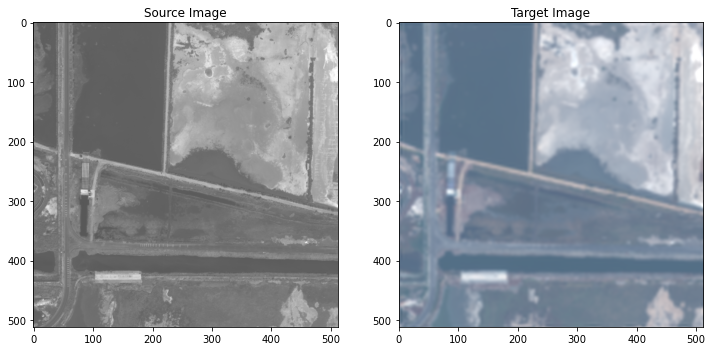

In [98]:
pl.figure(figsize=(12,6))
pl.subplot(1, 2,1)
pl.title('Source Image')
pl.imshow(Is_3d)
pl.subplot(1, 2,2)
pl.imshow(It_RGB)
pl.title('Target Image')

# SuperPixels

In [99]:
from skimage.color import rgb2gray

In [100]:
# Munich_nat markers=200 compactness=1e-8
# Trend markers=200 compactness=1e-8
# Mexi_nat markers=200 compactness=1e-8
# Mexi_urb markers=500 compactness=1e-8


In [101]:
gradient = filters.sobel(rgb2gray(It_RGB))
segment_water = segmentation.watershed(gradient, markers=200, compactness=1e-8) #compactness  higher mean more regular

Text(0.5, 1.0, 'Watershed Superpixels')

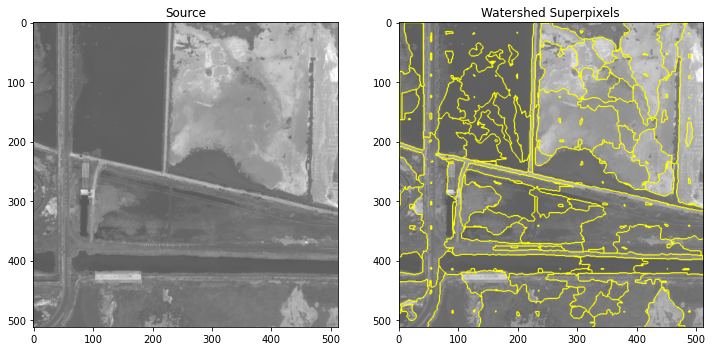

In [102]:
pl.figure(figsize=(12,6))

pl.subplot(1, 2,1)
pl.imshow(Is_3d)
pl.title("Source")

pl.subplot(1, 2,2)
pl.imshow(segmentation.mark_boundaries(Is_3d.numpy(), segment_water))
pl.title("Watershed Superpixels")

# Fast Wasserstein assignement for color transfer

In [103]:
gray_theta=torch.tensor([1,1,1],dtype=torch.double)

X=Is_3d.reshape((512*512,3))
Y_RGB=It_RGB.reshape((512*512,3))

In [104]:
#Applied the super pixel on source and target

segment=torch.tensor(segment_water)
n_segments=segment.max()
It_RGB2=It_RGB+(1e3*segment/n_segments)[:,:,None]
Y_RGB2=It_RGB2.reshape((512*512,3))

Is_3d2=Is_3d+(1e3*segment/n_segments)[:,:,None]
X2=Is_3d2.reshape((512*512,3))

In [105]:
#Compute assignement
_,u,v=SWGG_CP(X2,Y_RGB2,gray_theta.reshape(3,1))
X_trans=X.clone()
X_trans[u]=Y_RGB[v]
Is_RGB_water=X_trans.reshape((512,512,3))

(-0.5, 511.5, 511.5, -0.5)

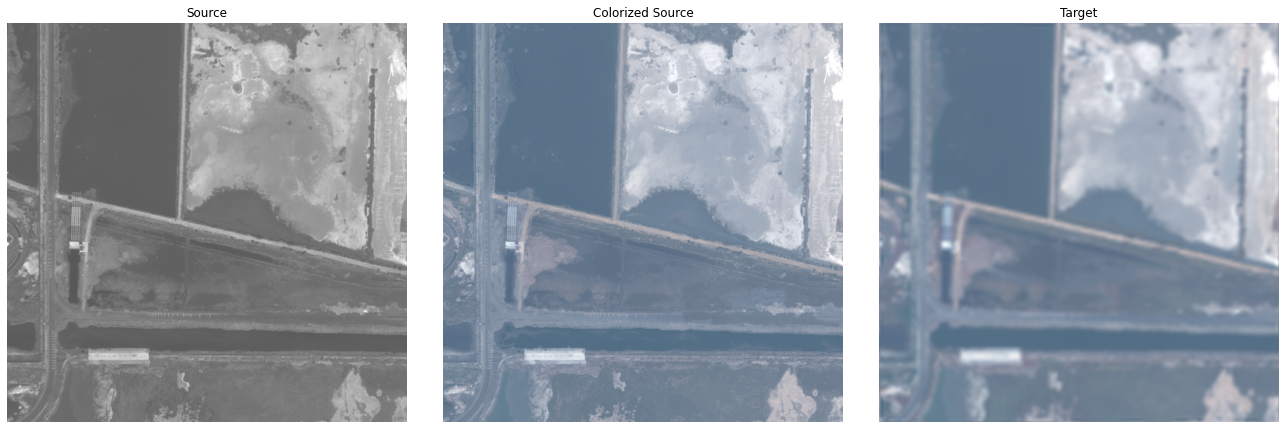

In [107]:
pl.figure(figsize=(18,6))
pl.subplot(1, 3,1)
pl.imshow(Is_3d)
pl.title("Source")
pl.axis('off')

pl.subplot(1, 3,2)
pl.imshow(Is_RGB_water)
pl.title("Colorized Source")
pl.axis('off')

pl.subplot(1, 3,3)
pl.imshow(It_RGB)
pl.title("Target")
pl.tight_layout()
pl.axis('off')